# Quick Start

The easiest way to get up and running is to load in one of our example datasets (or load in some data of your own) and to convert them to either a {py:class}`.HindcastEnsemble` or {py:class}`.PerfectModelEnsemble` object.

`climpred` provides various example datasets. See our [examples](examples.html) to see some analysis cases.

{py:class}`.PredictionEnsemble`

{py:class}`.HindcastEnsemble`
{py:class}`.PerfectModelEnsemble`

{py:meth}`.HindcastEnsemble.bootstrap`
{py:meth}`.HindcastEnsemble.verify`

{py:meth}`.PerfectModelEnsemble.bootstrap`
{py:meth}`.PerfectModelEnsemble.verify`

{py:class}`xarray.Dataset`

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr

from climpred import HindcastEnsemble
from climpred.tutorial import load_dataset
import climpred

xr.set_options(display_style="text")

<IPython.core.display.Javascript object>

You can view the datasets available to be loaded with the [load_datasets()](api/climpred.tutorial.load_dataset.html#climpred.tutorial.load_dataset) command without passing any arguments:

In [3]:
load_dataset()

'MPI-control-1D': area averages for the MPI control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the MPI control run of SST/SSS.
'MPI-PM-DP-1D': perfect model decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': perfect model decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'CESM-DP-SST': hindcast decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': hindcast decadal prediction ensemble of global mean SSS.
'CESM-DP-SST-3D': hindcast decadal prediction ensemble of eastern Pacific SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': hindcast initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.
'FOSI

<IPython.core.display.Javascript object>

From here, loading a dataset is easy. Note that you need to be connected to the internet for this to work -- the datasets are being pulled from the [climpred-data](https://github.com/pangeo-data/climpred-data) repository. Once loaded, it is cached on your computer so you can reload extremely quickly. These datasets are very small (< 1MB each) so they won't take up much space.

In [4]:
hind = climpred.tutorial.load_dataset("CESM-DP-SST")
# Add lead attribute units.
hind["lead"].attrs["units"] = "years"
obs = climpred.tutorial.load_dataset("ERSST")

<IPython.core.display.Javascript object>

Make sure your prediction ensemble's dimension labeling conforms to `climpred`'s [standards](setting-up-data.html). In other words, you need an `init`, `lead`, and (optional) `member` dimension. Make sure that your `init` and `lead` dimensions align.

Note that we here have a special case with `int`s in the `init` coords. For `CESM-DP`, a November 1st 1954 initialization should be labeled as `init=1954`, so that the `lead=1` forecast related to `valid_time=1955`.

In [5]:
print(hind.coords)

Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
  * init     (init) float32 1.954e+03 1.955e+03 ... 2.016e+03 2.017e+03


<IPython.core.display.Javascript object>

We'll quickly process the data to create anomalies. CESM-DPLE's drift-correction occurs over 1964-2014, so we'll remove that from the observations.

In [6]:
obs = obs - obs.sel(time=slice(1964, 2014)).mean("time")

<IPython.core.display.Javascript object>

We can create a [HindcastEnsemble](api/climpred.classes.HindcastEnsemble.html#climpred.classes.HindcastEnsemble) object and add our observations.

In [7]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs)
print(hindcast)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 ...
Observations:
    SST      (time) float32 -0.4015 -0.3524 -0.1851 ... 0.2481 0.346 0.4502
Uninitialized:
    None


/Users/aaron.spring/Coding/climpred/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<IPython.core.display.Javascript object>

`valid_time` for the `initialized` data shall be matched with `time` for `observations`.

In [8]:
hindcast.get_initialized().coords

Coordinates:
  * lead        (lead) int32 1 2 3 4 5 6 7 8 9 10
  * member      (member) int32 1 2 3 4 5 6 7 8 9 10
  * init        (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
    valid_time  (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00

<IPython.core.display.Javascript object>

In [9]:
hindcast.get_observations().coords

Coordinates:
  * time     (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00

<IPython.core.display.Javascript object>

`PredictionEnsemble.plot()` shows all associated datasets (`initialized`,`uninitialized` if present,`observations` if present) if only climpred dimension (`lead`,`init`,`member`,`time`) are present, e.g. `plot()` does not work for `lat`, `lon`, `model`, ...

<AxesSubplot:xlabel='validity time', ylabel='SST'>

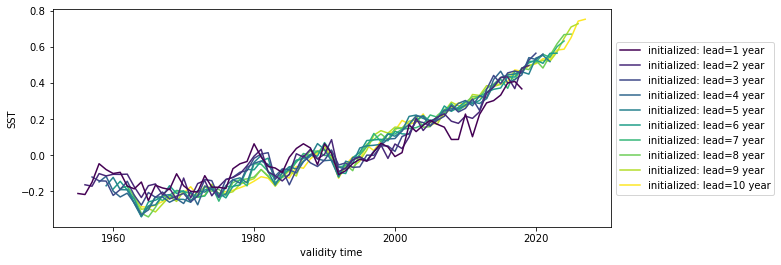

<IPython.core.display.Javascript object>

In [10]:
hindcast.plot()

We'll also remove a quadratic trend so that it doesn't artificially boost our predictability. `PredictionEnsemble.map(func)` tries to apply/map `func` to all associated datasets. 
Those calls do not raise errors such as `ValueError`, `KeyError`, `DimensionError`, but show respective warnings, which can be filtered away with `warnings.filterwarnings("ignore")`.

In [11]:
from climpred.stats import rm_poly

hindcast.map(rm_poly, dim="init", deg=2).map(rm_poly, dim="time", deg=2)

/Users/aaron.spring/Coding/climpred/climpred/classes.py:539: UserWarning: Error due to verification/control/uninitialized: rm_poly({'dim': 'init', 'deg': 2}) failed
KeyError: 'init'
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/classes.py:533: UserWarning: Error due to initialized:  rm_poly({'dim': 'time', 'deg': 2}) failed
KeyError: 'time'
  warnings.warn(f"Error due to initialized:  {msg}")


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 -0.09386 -0.07692 ... 0.07389 0.06577
Observations:
    SST      (time) float64 -0.1006 -0.05807 0.1026 ... -0.04652 0.03726 0.1272
Uninitialized:
    None

<IPython.core.display.Javascript object>

Alternatively, when supplying the `kwargs` `dim='init_or_time'`, the matching `dim` is applied only and hence does not raise `UserWarning`s.

<AxesSubplot:xlabel='validity time', ylabel='SST'>

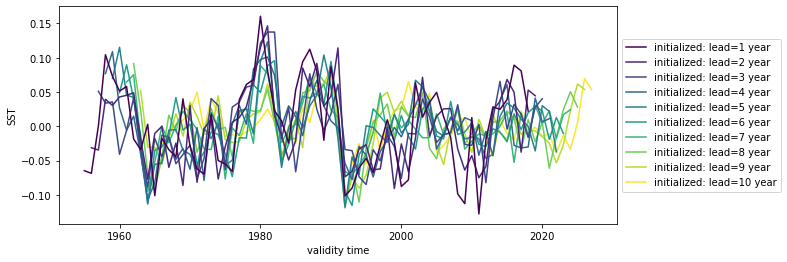

<IPython.core.display.Javascript object>

In [12]:
hindcast = hindcast.map(rm_poly, dim="init_or_time", deg=2)
hindcast.plot()

Now we'll quickly calculate skill against persistence. We require users to define `metric`, `comparison`, `dim`, and `alignment`. This ensures that `climpred` isn't treated like a black box -- there are no "defaults" to the prediction analysis framework. You can choose from a variety of possible [metrics](https://climpred.readthedocs.io/en/latest/metrics.html) by entering their associated strings. [Comparison](https://climpred.readthedocs.io/en/latest/comparisons.html) strategies vary for hindcast and perfect model systems. Here we chose to compare the ensemble mean to observations (`'e2o'`). We reduce this operation over the initialization dimension. Lastly, we choose the `'same_verif'` alignment, which uses the same set of verification dates across all leads (see alignment strategies [here](https://climpred.readthedocs.io/en/latest/alignment.html)).

An optional keyword used here is `reference`. Here, we ask to compute the `'acc'` metric with a persistence forecast, so that we can establish skill over some baseline forecast.

In [13]:
result = hindcast.verify(
    metric="rmse",
    comparison="e2o",
    dim="init",
    alignment="same_verif",
    reference="persistence",
)
print(result)

<xarray.Dataset>
Dimensions:  (skill: 2, lead: 10)
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * skill    (skill) <U11 'initialized' 'persistence'
Data variables:
    SST      (skill, lead) float64 0.05722 0.06441 0.06859 ... 0.1053 0.09374


<IPython.core.display.Javascript object>

In [14]:
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["lines.marker"] = "o"
plt.rcParams["figure.figsize"] = (8, 3)

<IPython.core.display.Javascript object>

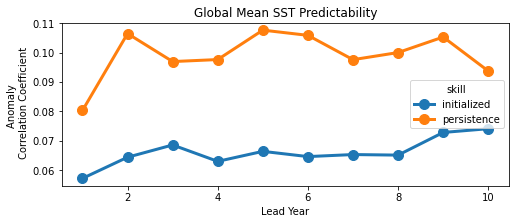

<IPython.core.display.Javascript object>

In [15]:
result.SST.plot(hue="skill")
plt.title("Global Mean SST Predictability")
plt.ylabel("Anomaly \n Correlation Coefficient")
plt.xlabel("Lead Year")
plt.show()

We can also check the accuracy/error, i.e. root-mean-square-error `rmse`, of our forecasts against multiple `reference`s. Choose `reference` from [`climatology`,`persistence`,`uninitialized`].

In [16]:
result = hindcast.verify(
    metric="rmse",
    comparison="e2o",
    dim="init",
    alignment="same_verif",
    reference=["persistence", "climatology"],
)

<IPython.core.display.Javascript object>

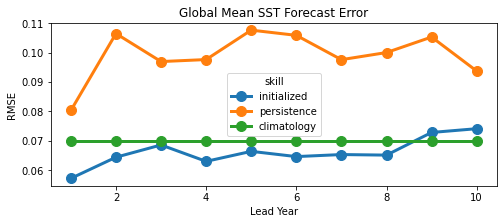

<IPython.core.display.Javascript object>

In [17]:
result.SST.plot(hue="skill")
plt.title("Global Mean SST Forecast Error")
plt.ylabel("RMSE")
plt.xlabel("Lead Year")
plt.show()